# Running an OGC Application in an ADES

In [1]:
import time
import os
import kubernetes
import s3fs
import xarray as xr
from ades_client import create_api_client

Set up API client interfaces for Kubernetes and ADES

In [2]:
kubernetes.config.load_config()
kube_client = kubernetes.client.CoreV1Api()
ades_client = create_api_client('127.0.0.1', 5000)

Deploy the application as a process

In [3]:
ades_client.deployProcess(params=dict(proc='https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/application_descriptor.json'))

{'deploymentResult': {'processSummary': {'executionUnit': [{'href': 'docker://jplzhan/ci-generated-images:unity-sds.unity-analytics-bcdp.main'}],
   'immediateDeployment': True,
   'processDescription': {'jobControlOptions': ['async-execute'],
    'outputTransmission': ['reference'],
    'process': {'abstract': 'Application Package Demo',
     'id': 'unity-sds.unity-analytics-bcdp.main-3.0.0',
     'inputs': [{'id': 'workflow_variable',
       'literalDataDomains': [{'dataType': {'name': ['string']}}],
       'title': 'Automatically detected using papermill.'},
      {'id': 'workflow_dataset_path_name',
       'literalDataDomains': [{'dataType': {'name': ['string']}}],
       'title': 'Automatically detected using papermill.'},
      {'id': 'workflow_base_dataset_url',
       'literalDataDomains': [{'dataType': {'name': ['string']}}],
       'title': 'Automatically detected using papermill.'},
      {'id': 'workflow_aws_secret_access_key',
       'literalDataDomains': [{'dataType': {'n

Show process information from ADES

In [4]:
processes = ades_client.getProcesses()
processes

{'processes': [{'abstract': 'Application Package Demo',
   'executionUnit': 'docker://jplzhan/ci-generated-images:unity-sds.unity-analytics-bcdp.main',
   'id': 'unity-sds.unity-analytics-bcdp.main-3.0.0',
   'immediateDeployment': 'true',
   'jobControlOptions': ['async-execute'],
   'keywords': 'Demo',
   'outputTransmission': ['reference'],
   'owsContextURL': 'https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/workflow.cwl',
   'processVersion': '3.0.0',
   'title': 'BCDP'}]}

Execute a job with given input parameters

In [5]:
proc = processes['processes'][0]
data = dict(workflow_base_dataset_url='s3://unity-dev-as-s3-analytics/data/',
            workflow_dataset_path_name='CORDEX_Africa',
            workflow_variable='pr',
            workflow_aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
            workflow_aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
            workflow_aws_session_token=os.environ['AWS_SESSION_TOKEN'])
job = ades_client.execute(proc['id'], json=data)
job

{'jobID': 'unity-sds.unity-analytics-bcdp.main-3.0.0-a814eaa843adcddc04e162ae8416e60cb9495096',
 'status': 'accepted'}

Print job info

In [6]:
jobs = ades_client.getJobList(proc['id'])
jobs

{'jobs': [{'backend_info': '{"status": "accepted", "k8s_tmpout_pvc_name": "tmpout-8t3ge3pxx24l", "k8s_output_pvc_name": "output-data-8t3ge3pxx24l", "k8s_job_id": "calrissian-job-8t3ge3pxx24l", "api_response": {"apiVersion": "batch/v1", "kind": "Job", "metadata": {"creationTimestamp": "2022-08-15T22:57:42+00:00", "generation": 1, "labels": {"controller-uid": "9d59b0a8-26b5-43a9-9100-f9d272340374", "job-name": "calrissian-job-8t3ge3pxx24l"}, "managedFields": [{"apiVersion": "batch/v1", "fieldsType": "FieldsV1", "fieldsV1": {"f:spec": {"f:backoffLimit": {}, "f:completionMode": {}, "f:completions": {}, "f:parallelism": {}, "f:suspend": {}, "f:template": {"f:spec": {"f:containers": {"k:{\\"name\\":\\"calrissian-job\\"}": {".": {}, "f:args": {}, "f:command": {}, "f:env": {".": {}, "k:{\\"name\\":\\"CALRISSIAN_DELETE_PODS\\"}": {".": {}, "f:name": {}, "f:value": {}}, "k:{\\"name\\":\\"CALRISSIAN_POD_NAME\\"}": {".": {}, "f:name": {}, "f:valueFrom": {".": {}, "f:fieldRef": {}}}}, "f:envFrom": 

Log the job output from k8s

In [8]:
time.sleep(5)
pod = kube_client.list_namespaced_pod('ades').items[0].metadata.name
for line in kube_client.read_namespaced_pod_log(pod, 'ades', follow=True, _preload_content=False).stream():
    print(line.decode())

INFO calrissian 0.10.0 (cwltool 3.1.20220512223411)

https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/stage_in.cwl:6:3: Warning: checking

                                                                                        item


                                                                                        `class` contains

                                                                                        undefined reference

                                                                                        to

                                                                                        `http://commonwl.org/cwltool#Secrets`

INFO https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/stage_in.cwl:6:3: Unknown hint

                                                                                        http://commonwl.org/cwltool#Secrets

https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/stage_out

Confirm job result in ADES

In [9]:
job = jobs['jobs'][0]
ades_client.getResult(proc['id'], job['jobID'])

{'jobID': 'unity-sds.unity-analytics-bcdp.main-3.0.0-a814eaa843adcddc04e162ae8416e60cb9495096',
 'links': [{'href': 'https://mypath',
   'rel': 'result',
   'title': 'mytitle',
   'type': 'application/json'}],
 'status': 'successful'}

Undeploy the process from the ADES and cleanup any k8s pods

In [10]:
ades_client.undeployProcess(proc['id'])

{'undeploymentResult': {'abstract': 'Application Package Demo',
  'executionUnit': 'docker://jplzhan/ci-generated-images:unity-sds.unity-analytics-bcdp.main',
  'id': 'unity-sds.unity-analytics-bcdp.main-3.0.0',
  'immediateDeployment': 'true',
  'jobControlOptions': ['async-execute'],
  'keywords': 'Demo',
  'outputTransmission': ['reference'],
  'owsContextURL': 'https://raw.githubusercontent.com/unity-sds/unity-analytics-bcdp/main/workflow.cwl',
  'processVersion': '3.0.0',
  'title': 'BCDP'}}

In [11]:
kube_client.delete_collection_namespaced_pod('ades')

{'api_version': 'v1',
 'code': None,
 'details': None,
 'kind': 'PodList',
 'message': None,
 'metadata': {'_continue': None,
              'remaining_item_count': None,
              'resource_version': '258649',
              'self_link': None},
 'reason': None,
 'status': None}

Let's take a quick look at the output

In [12]:
fs = s3fs.S3FileSystem()
f = fs.open(f"{data['workflow_base_dataset_url']}stage_out/CORDEX_Africa_clt.nc")
ds = xr.open_dataset(f).rename(CORDEX='pr')
ds

<xarray.Dataset>
Dimensions:  (time: 229, y: 100, x: 97, names: 8)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2008-12-01
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * x        (x) float64 -24.64 -23.76 -22.88 -22.0 ... 57.2 58.08 58.96 59.84
  * y        (y) float64 -45.76 -44.88 -44.0 -43.12 ... 38.72 39.6 40.48 41.36
  * names    (names) object 'CNRM-ARPEGE51' 'DMI-HIRHAM' ... 'UCT-PRECIS' 'ENS'
Data variables:
    pr       (names, time, y, x) float64 ...

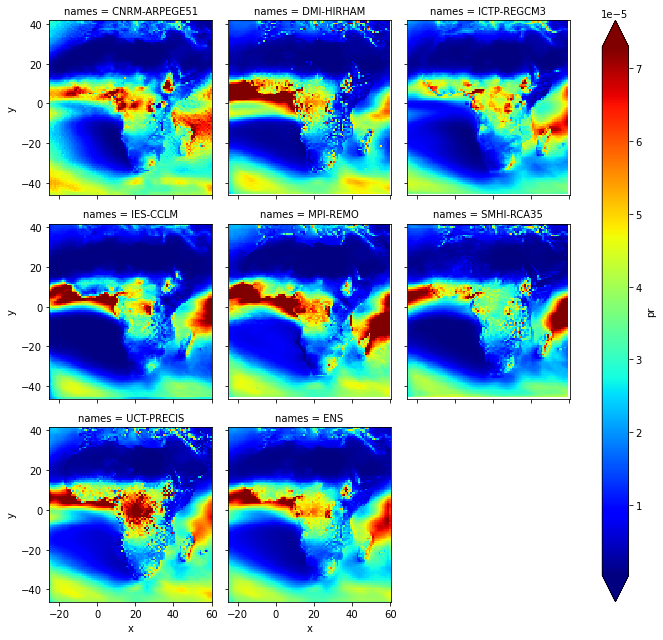

In [13]:
(ds.pr
   .mean('time')
   .plot(x='x', y='y', col='names', col_wrap=3, robust=True, cmap='jet')
)